# Data Normalization

## Load Data

In [1]:
import os
from pathlib import Path
def load_memmap_directories(basepath):
    memmap_dirs = []
    for root, dirs, files in os.walk(basepath):
        for dir in dirs:
            memmap_dirs.append(os.path.join(root, dir))
    return memmap_dirs
# Load all memmap directories in the test output directory


In [2]:
Path(os.getcwd())/"raw"/str(0)

PosixPath('/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/dev/explore/data-engineering/raw/0')

In [3]:
heuristic_types = [0,2]
memmap_dirs = load_memmap_directories(Path(os.getcwd())/"raw"/str(0)) + load_memmap_directories(Path(os.getcwd())/"raw"/str(2))
memmap_dirs

['/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/dev/explore/data-engineering/raw/0/000952ab-e1dd-4885-9729-c419e9c43f20',
 '/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/dev/explore/data-engineering/raw/0/000ebd28-6b5f-47fc-a5f0-d90fad80bb6f',
 '/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/dev/explore/data-engineering/raw/0/0058e08c-a647-4bdf-b6ad-3400251a4aad',
 '/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/dev/explore/data-engineering/raw/0/0324c353-0c48-43d0-baff-2a4e287f75c9',
 '/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/dev/explore/data-engineering/raw/0/03c5a1e8-4c08-42f5-9998-a94b510536b5',
 '/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/dev/explore/data-engineering/raw/0/054660c0-e809-4ee5-8a82-fc527f1919d3',
 '/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/dev/explore/data-engineering/raw/0/0681e653-2f67-4484-aef8-c75f38a80127',
 '/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/dev/explore/data-engineering/raw/0/069f296b-107d-4fe6-a589-3e59077

In [4]:
len(memmap_dirs)

1007

In [5]:
from torchrl.data import LazyMemmapStorage
from tensordict import TensorDict

In [6]:
# Create a replay buffer
from torchrl.data import ReplayBuffer
from torchrl.data.replay_buffers import TensorDictReplayBuffer

loaded_data = [TensorDict.load_memmap(d) for d in memmap_dirs]

In [7]:
len(loaded_data)

1007

In [35]:
# import torch
# for d in loaded_data:
#     print(d.batch_size == torch.Size([0]))
#     print(d['observation'])

## Normalization

In [8]:
# normalize loaded_data observation, next_observation and reward

import torch

# Concatenate all data for statistics
all_obs = torch.cat([d['observation'] for d in loaded_data if d.batch_size != torch.Size([0])], dim=0)
all_next_obs = torch.cat([d['next_observation'] for d in loaded_data if d.batch_size != torch.Size([0])], dim=0)
all_rewards = torch.cat([d['reward'] for d in loaded_data if d.batch_size != torch.Size([0])], dim=0)

In [9]:
# Get all rewards less than 100

len(all_rewards)

80767

### Visualize Rewards Distribution

In [137]:
import matplotlib.pyplot as plt

In [132]:
REWARDS_DELINEATION = 1.8e4

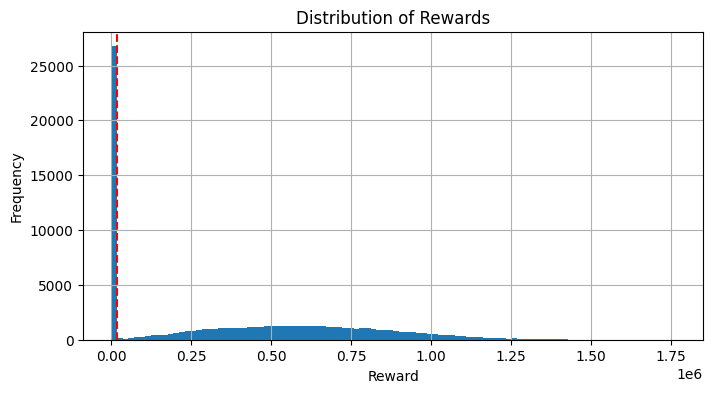

In [138]:
plt.figure(figsize=(8, 4))
plt.hist(all_rewards.cpu().numpy(), bins=100)
plt.axvline(REWARDS_DELINEATION, color='r', linestyle='--', label='1.8e4')
plt.title("Distribution of Rewards")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Add vertical line dash with value 1.8e4


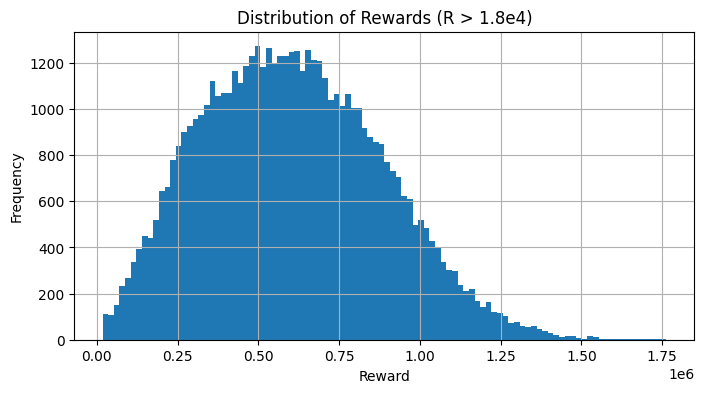

In [139]:
plt.figure(figsize=(8, 4))
plt.hist(all_rewards[all_rewards >= REWARDS_DELINEATION].cpu().numpy(), bins=100)
plt.title("Distribution of Rewards (R > 1.8e4)")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


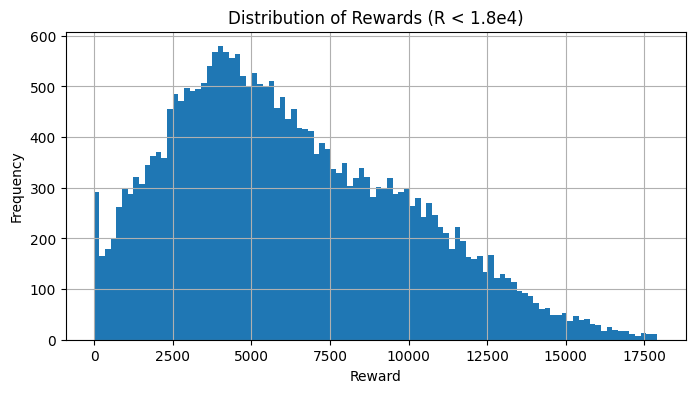

In [140]:

plt.figure(figsize=(8, 4))
plt.hist(all_rewards[all_rewards < 1.8e4].cpu().numpy(), bins=100)
plt.title("Distribution of Rewards (R < 1.8e4)")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Statistics

In [142]:
# Compute mean and std for observations
obs_mean = all_obs.mean(dim=0)
obs_std = all_obs.std(dim=0) + 1e-8  # avoid division by zero

next_obs_mean = all_next_obs.mean(dim=0)
next_obs_std = all_next_obs.std(dim=0) + 1e-8

# Compute max absolute reward for normalization
# max_abs_reward = all_rewards[all_].abs().max() + 1e-8

reward_mean = all_rewards[all_rewards > REWARDS_DELINEATION].mean(dim=0)
reward_std = all_rewards[all_rewards > REWARDS_DELINEATION].std(dim=0) + 1e-8

In [ ]:
#reward_mean

tensor(605783.5625)

#### Save Stats

In [147]:
import pickle

stats = {
    "obs_mean": obs_mean.cpu().numpy(),
    "obs_std": obs_std.cpu().numpy(),
    "next_obs_mean": next_obs_mean.cpu().numpy(),
    "next_obs_std": next_obs_std.cpu().numpy(),
    "reward_mean": reward_mean.cpu().numpy(),
    "reward_std": reward_std.cpu().numpy(),
}

with open("./data_stats/normalization_stats.pkl", "wb") as f:
    pickle.dump(stats, f)

print("Saved normalization statistics to ./data_stats/normalization_stats.pkl")

Saved normalization statistics to ./data_stats/normalization_stats.pkl


### Normalize Data

In [143]:
# Normalize each TensorDict in loaded_data
for d in loaded_data:
    if d.batch_size != torch.Size([0]):
        d['observation'] = (d['observation'] - obs_mean) / obs_std
        d['next_observation'] = (d['next_observation'] - next_obs_mean) / next_obs_std
        d['reward'] = (d['reward'] - reward_mean) / reward_std

In [144]:
all_obs_norm = torch.cat([d['observation'] for d in loaded_data if d.batch_size != torch.Size([0])], dim=0)
all_next_obs_norm = torch.cat([d['next_observation'] for d in loaded_data if d.batch_size != torch.Size([0])], dim=0)
all_rewards_norm = torch.cat([d['reward'] for d in loaded_data if d.batch_size != torch.Size([0])], dim=0)

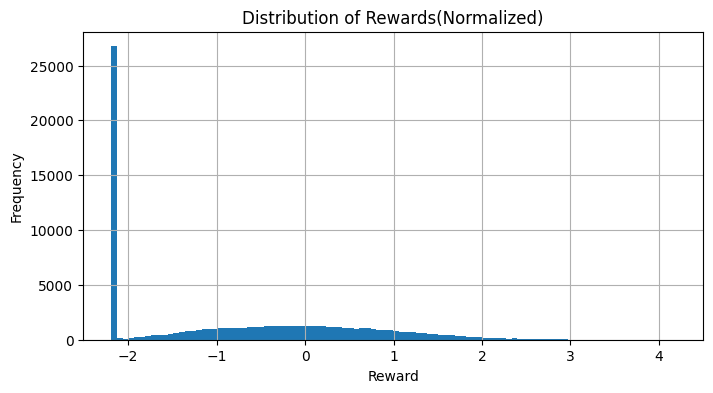

In [145]:
plt.figure(figsize=(8, 4))
plt.hist(all_rewards_norm.cpu().numpy(), bins=100)
plt.title("Distribution of Rewards(Normalized)")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### 